# Лабораторная работа №1.3 "Эффект Рамзауэра"

<center> Исследуется энергетическая зависимость вероятности рассеяния электронов атомами ксенона, определяются энергии электронов, при которых наблюдается "просветление" (не объяснимо в рамках классической физики) ксенона, и оценивается размер его внешней электронной оболчки. </center>

### Измерение ВАХ

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [128]:
df_vah = pd.read_csv('vah.csv', delimiter=';', dtype=float)
df_vah.head()

,V_I,V
0,0.1,-0.013
1,1.6,0.800
2,3.7,0.895
3,12.0,1.047
4,34.5,1.250


In [129]:
# В описании указано, что ток получается делением на 100 кОм
multiplier = (100*10**3)**(-1)
# Ток будем считать в мА
multiplier *= 10**3
df_vah['I'] = df_vah['V_I'] * multiplier

In [130]:
def paint_dots(*args, **kwargs):
    fig, ax = plt.subplots()
    for i in args:
        x_data, y_data = i['x'], i['y']
        
        if('isScatter' in i):
            is_scatter = i['isScatter']
        else:
            is_scatter = True
        
        if('label' in i):
            label = i['label']
        else:
            label = 'Graph'
        
        if('x_label' in i):
            x_label = i['x_label']
        else:
            x_label = r'$V$, В'
        
        if('y_label' in i):
            y_label = i['y_label']
        else:
            y_label = r'$I$, мА'
            
        if is_scatter:
            ax.scatter(x_data, y_data, label=label)
        else:
            ax.plot(x_data, y_data, label=label)
    
    ax.grid()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    # Ставим title
    if('title' in kwargs):
        ax.set_title(kwargs['title'])
    else:
        ax.set_title('ВАХ')
    
    # Сохраняем график
    if('filename' in kwargs):
        fig.savefig(kwargs['filename'])
    else:
        fig.savefig('out1.pdf')

Посмотрим, что из себя представляет ВАХ

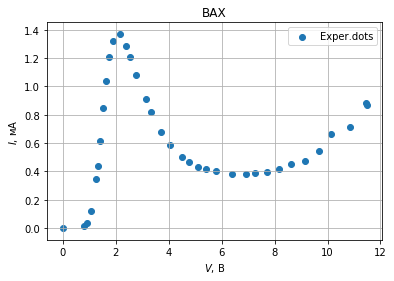

In [131]:
x, y = df_vah.V, df_vah.I

# Сортируем, чтобы сплайны работали хорошо
y = y[x.argsort()]
x = np.sort(x)

paint_dots(
    {'x': x, 'y': y, 'isScatter': True, 'label': r'Exper.dots'}
)

Эту картину мы получали на осциллографе.

Поищем зависимость вероятности рассеяния электрона от его энергии из соотношения:
$$
\omega (V) = - \dfrac{1}{C} \ln \dfrac{I_a (V)}{I_0}
$$
Здесь $C = L n_a \Delta_a$ и $I_0 = e N_0$, где

$n_a$ - концентрация атомов газа в лампе, $L$ - длина лампы, $\Delta_a$ - площадь поперечного сечения атома, $N_0$ - начальный поток электронов.

In [132]:
def to_omega(x_data, y_data, C=1, I_0=1):
    return [x_data, -1/C * np.log(y_data / I_0)]

In [133]:
# TODO: Пересчитать C и I_0 по формулам
C, I_0 = 1, 10**3
I_0 = np.max(y)
N_0 = I_0 * 10**3 / 1.6*10**(19) # Пересчитаем N_0, для себя :)

In [207]:
# Пересчитаем C у учетом нормировки интеграла
import scipy as sc
C = 1/sc.integrate.simps(y, x=x)
print('.  ', 'C =', C)

.   C = 0.15126036295526835


In [246]:
# Пробуем сплайн
from scipy.interpolate import UnivariateSpline

x_omega, y_omega = to_omega(x, y, C, I_0)

spl = UnivariateSpline(x_omega, y_omega, k=3)
spl.set_smoothing_factor(5)

x_spl = np.linspace(x_omega[0], x_omega[-1], 1000)
y_spl = spl(x_spl)

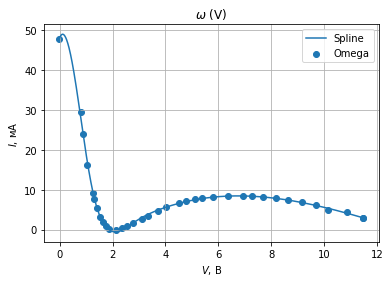

In [247]:
paint_dots(
    {'x': x_omega,
     'y': y_omega, 
     'isScatter': True, 'label': r'Omega',
     'y_label': r'$\omega$',
     'filename': 'out2.pdf'
    },
    {'x': x_spl, 'y': y_spl, 'isScatter': False, 'label': r'Spline'}
    , filename='out2.pdf', title='$\omega$ (V)')

In [248]:
print('  Имеем коэффициенты: I_0 = {0:.2f} мА, C = {1:.3f}'.format(I_0, C))

  Имеем коэффициенты: I_0 = 1.37 мА, C = 0.151


### Определим газ в тиратроне

В ходе эксперимента была получена оценка напряжения пробоя:
$ E_\text{проб} \approx 12 \text{ эВ} $

На основании нее мы получим, что газ в тиратроне был **ксенон**.

### Оценим размер электронной оболочки

Исходя из значения коэффициента $C$ и его формулы выше, можно найти $\Delta_a$:

In [270]:
def make_estimation(C, n_a = N_0):
    # Тут мы делаем:
    #    1) N_0 = N_a (для оценки)
    #    2) L = 10 см
    L = 0.1
    delta_a = C / n_a * 10**3 / L
    # А из delta_a мы найдем радиус как sqrt(delta_a/ pi)
    return np.sqrt(delta_a / np.pi)
    
print('   Оценка радиуса атома: {0:.2f} А'.format(make_estimation(C) * 10**10))

   Оценка радиуса атома: 2.37 А


Истинный размер атома ксенона $r_{Xe} = 2.16 \text{ А}$

### Оценим напряжения максимумов

Проведем экстраполяцию и посмотрим, к чем она приведет

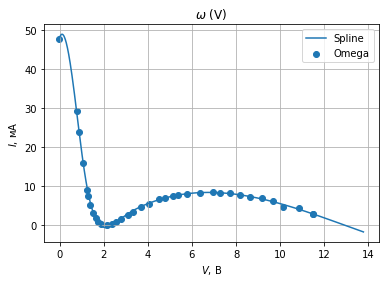

In [251]:
x_spl_extra = np.linspace(min(x_omega), max(x_omega)*1.2, 1000)
paint_dots(
    {'x': x_omega,
     'y': y_omega, 
     'isScatter': True, 'label': r'Omega',
     'y_label': r'$\omega$',
     'filename': 'out2.pdf'
    },
    {'x': x_spl_extra, 'y': spl(x_spl_extra), 'isScatter': False, 'label': r'Spline'}
    , filename='out3.pdf', title='$\omega$ (V)')

Видно, что вторая энергия больше 12.1 эВ (потенциала ионизации ксенона). Следовательно, на $n=2$ у нас уже будет ионизация ксенона и пробой тиратрона. Это подтверждает вывод лабника о том, что далее первого максимума наблюдать не удастся.